# <span style="color:blueviolet">PocketText</span>
Alexandre, Leonardo

In [1]:
import funcoesTp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from math import ceil
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("dados-eleicao-pocket-completa.csv", sep=';', parse_dates=["data_pesquisa"])
df[["pesquisa_id", "instituto", "unidade_federativa_nome", "tipo", "voto_tipo", "data_pesquisa", "partido", "percentual"]]

,pesquisa_id,instituto,unidade_federativa_nome,tipo,voto_tipo,data_pesquisa,partido,percentual
0,3517,MDA,BRASIL,Estimulada,Votos Totais,2017-02-11,PSC,11.7
1,3517,MDA,BRASIL,Estimulada,Votos Totais,2017-02-11,PSC,11.3
2,3517,MDA,BRASIL,Estimulada,Votos Totais,2017-02-11,PSC,12.0
3,3517,MDA,BRASIL,Espontanea,Votos Totais,2017-02-11,PSC,6.5
4,7630,Parana Pesquisas,ALAGOAS,Estimulada,Votos Totais,2017-03-09,PSL,10.2
...,...,...,...,...,...,...,...,...
904,8782,Serpes,GOIAS,Rejeicao,Votos Totais,2018-10-06,PSL,30.5
905,8476,Vox Populi,BRASIL,Estimulada,Votos Totais,2018-10-06,PSL,34.0
906,8476,Vox Populi,BRASIL,Estimulada,Votos Validos,2018-10-06,PSL,40.0
907,8485,Ibope,BRASIL,Estimulada,Votos Validos,2018-10-07,PSL,45.0


## <span style="color:blueviolet">Problema e relevancia</span>

<p align="justify">Nas eleições presidenciais de 2018, foi vista uma forte presença do uso de redes sociais como forma primária de comunicação de um dos candidatos, Jair Bolsonaro.  
<br>Essa guinada nada convencional do discurso público, da tv para redes sociais, deixou muitos analistas políticos desnorteados.
<br>Vimos assim a importância de utilizar metodologias computacionais para buscar correlações entre o discurso deste canditado em suas postagens com o aumento de sua popularidade nas pesquisas eleitorais, visto que tal metodologia poderia ser aplicada em futuras eleições para complementar a interpretação de cenários políticos.</p>

## <span style="color:blueviolet">Modelagem</span>
- <span style="color:coral">(a) qual tarefa/problema a ser resolvido?;</span>
- <span style="color:coral">(b) o que é a instância deste problema e como ela é representada: Quais são os atributos e o que
significa a classe alvo?</span>

<p align="justify">O problema consiste em extratir dados de uma determinada rede social deste candidato, no caso o Twitter, e transformar em métricas para podermos usar um modelo de aprendizado de máquinas tentando prever a aprovação deste candidato, conforme pesquisas eleitorais, dado seu engajamento nesta rede social.
<br>Usamos como instancia um grupo de tweets pré processado em métricas numéricas limitado por intervalos de tempos definidos pelas pesquisas naquele periodo, que representam nossa classe alvo.
<br>As métricas extraidas diretamente dos dados dos tweets foram a quantidade de favoritos o tweet recebeu e a quantidade de vezes que ele foi compartilhado e as métricas modeladas foram as classes gramaticas o sentimento e a sbjetividade extraidos do texto dos tweets.</p>

<p align="justify">Desta forma o que se quer saber é:  
    
- Qual a relação entre o número de compartilhamentos e favoritos com sua performance nas pesquisas?
- Existe alguma correlação com o que o candidato escreve em seus tweets com sua performance nas pesquisas?</p>

In [3]:
df_tweets = pd.read_csv("tweets-cat-tag.csv", sep=',', parse_dates=["created_at"])
df_tweets.drop(columns=['in_reply_to_screen_name', 'retweeted_status_screen_name', 'source', 'id'], inplace=True)

In [4]:
# dados extraidos
df_tweets[['created_at', 'text', 'retweet_count', 'favorite_count']].head()

,created_at,text,retweet_count,favorite_count
0,2018-10-28 23:28:12,Jair Bolsonaro fala pela primeira vez como Pre...,5199,33917
1,2018-10-28 23:26:01,Obrigado pela confiança! Vamos juntos mudar o ...,29207,135263
2,2018-10-28 23:13:01,BRASIL! 🇧🇷👍🏻,51825,211283
3,2018-10-28 01:38:42,@lobaoeletrico 👍🏻🇧🇷,565,4489
4,2018-10-28 00:59:06,"ATÉ A VITÓRIA, SE DEUS QUISER! 🇧🇷🇧🇷🇧🇷🇧🇷 https:...",19733,91936


In [5]:
# dados minarados a partir do texto
df_tweets.drop(columns=['created_at', 'text', 'retweet_count', 'favorite_count']).head()

,sentimento,subjetividade,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRT,PRON,VERB,.,X
0,0.25,0.333333,2,2,0,0,1,5,0,0,0,1,0,0
1,0.00,0.000000,0,1,1,0,0,5,0,1,2,2,0,0
2,0.00,0.000000,0,0,0,0,0,2,0,0,0,0,0,0
3,0.00,0.000000,1,0,0,0,0,2,0,0,0,0,0,0
4,1.00,0.400000,1,0,0,0,0,6,0,0,0,1,0,0


## <span style="color:blueviolet">Análise de trabalhos relacionados</span>
- <span style="color:coral">Apresente trabalhos similares ao seu. Sobre esses
trabalhos, descreva qual é o preprocessamento que é usualmente feito, qual abordagem
escolhida e também quais são os resultados obtidos.</span>

<p align="justify">A parte de nosso trabalho que envolve tweets e pré-processamento traça paralelos 
com vários outros trabalhos feitos sobre processamento textual.
<br><br><i>Pandarachalil, R., Sendhilkumar, S. & Mahalakshmi, G.S. Cogn Comput (2015) 7: 254. https://doi.org/10.1007/s12559-014-9310-z</i>
<br>Fazem escolhas de pré-processamento com remoções dos links em texto, ajustes de peso em palavras com letras repetidas (e.g. "dooooooido") e ajustes nas contrações em inglês("didn't -> did not").  
<br><br>Já <i>Araujo, Matheus and Diniz, Joao P and Bastos, Lucas and Soares, Elias and Ferreira, Miller and Ribeiro, Filipe and Benevenuto, Fabrício (2016) </i>https://homepages.dcc.ufmg.br/~matheus.araujo/ifeel2.pdf obtiveram ótimos resultados com o método que decidimos implementar onde um conjuntos de dados em português, foi traduzido para inglês para então extrair a análize de sentimento.
<br><br>Não encontramos até o momento uma metodologia para lidar com a classe alvo da forma que estamos propondo, a metodologia será investigada com detalhes.

## <span style="color:blueviolet">Análise dos dados</span>
- <span style="color:coral">Quais tipos de dados serão os atributos?</span>
- <span style="color:coral">Existem ruídos, valores inválidos ou inexistentes para algum atributo?</span>
- <span style="color:coral">Qual preprocessamento é necessário para os tipos de atributos e métodos que serão utilizados</span>

<p align="justify">Serão usados dois atributos extraidos diretamente dos tweets, quais são, favorito e compartilhado, e quatorze preprocessados a partir do texto do tweet, sentimento, subjetividade, adjetivos, adverbios de posição, adverbios, conjunções, artigos, substantivos, numerais, preposições, pronomes, verbos, pontuações e outros presentes no texto.
<br>Para extrair o sentimento, a subjetividade e a classe gramatical do texto, primeiramente passamos a linguagem para o inglês, conforme verificado no artigo "A Multilingual Benchmarking System for Sentence-Level Sentiment Analysis", para melhor classificação das métricas, e finalmente utilizamos o TextBlob para extrair as métricas.</p>  

- Existem nos sentimentos e subjetividades valores igual a zero. Estes valores podem indicar que o tweet é neutro ou que não foi classificado.  
- Os favoritos de um tweet compartilhado por outro usuário não são contabilizados e, portanto, apresentam a métrica zerado.

<p align="justify">Os dados das pesquisas eleitorais foram tratados de forma mais seletiva.  
    
- Foram extraidas as pesquisas de forma expontânea, entendendo que as mesmas conflitam com os resultados das estimuladas, da mesma forma extraimos as pesquisas de votos válidos, entendendo que estas conflitam com os resultados dos votos totais.  
- Os institutos que realizaram menos de 8 pesquisas ao longo do periodo avaliado também foram ignorados por entendermos que seriam poucos resultados para formar uma função relevante.
- Para pesquisas com diferentes cenários na mesma data, as juntamos em uma só média</p>

C:\Users\leo_r\Miniconda3\envs\keras-gpu\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


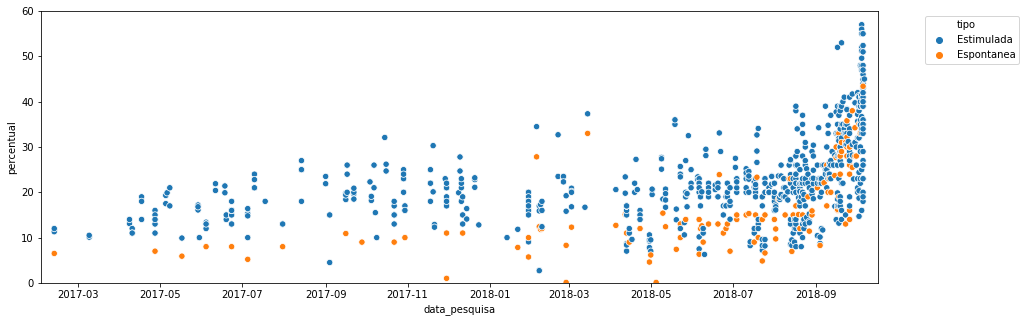

In [6]:
# por tipo (estimulada e espontanea)
plt.rcParams['figure.figsize'] = [15, 5]
df_temp = df[df.tipo != "Rejeicao"]
funcoesTp.visual_plots(df_temp, "tipo")

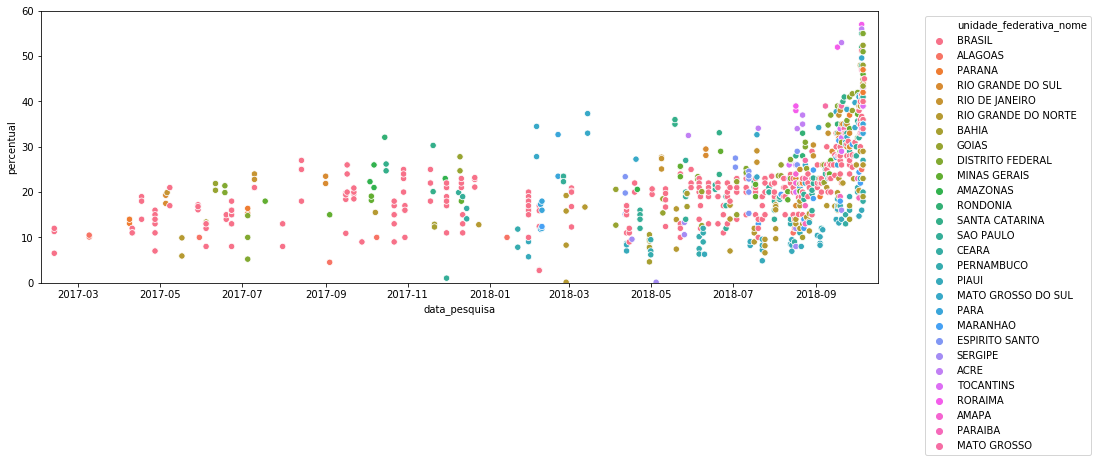

In [7]:
# por UF
plt.rcParams['figure.figsize'] = [15, 5]
df_temp = df[df.tipo != "Rejeicao"]
funcoesTp.visual_plots(df_temp, "unidade_federativa_nome")

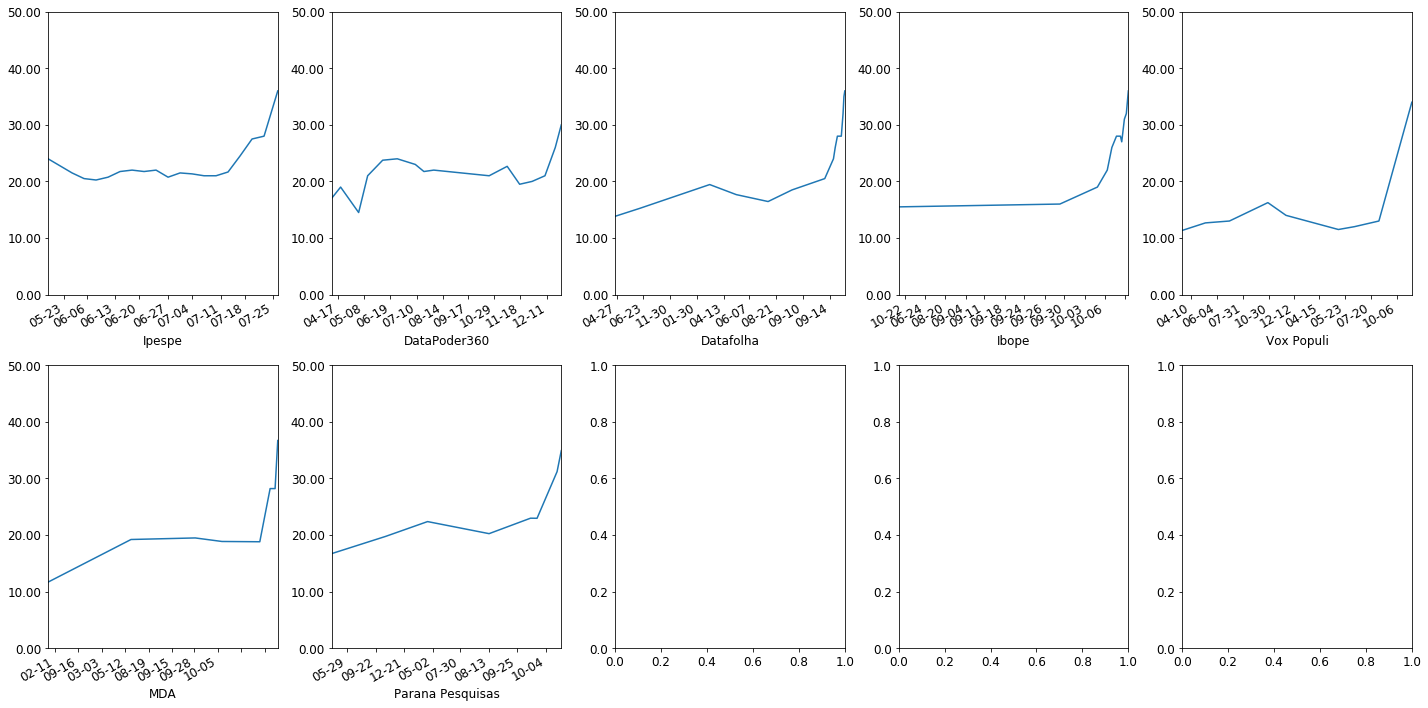

In [8]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(ceil(len(funcoesTp.institutos8)/5),5)

for i, inst in enumerate(funcoesTp.institutos8):
    df_temp = funcoesTp.df_plot[funcoesTp.df_plot.instituto == inst]
    ax = df_temp["percentual"].plot(ax=axs[i//5][i%5])
    ticklabels = df_temp.index.strftime("%m-%d")
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.set_ylim([0,50])
    axs[i//5][i%5].set(xlabel="{}".format(inst))
plt.tight_layout()

## <span style="color:blueviolet">Preprocessamento usado</span>
- <span style="color:coral">Apresente a abordagem proposta e qual método usado, justifique.</span>

<p align="justify">O engajamento no Twitter, favoritos e compartilhamento já possuiam sua métrica própria e suficientes para o trabalho.
<br>Contudo, para melhorar a precisão, inserimos métricas que conseguissem expressar em números os textos nos tweets.
<br>O sentimento e a subjetividade poderiam medir o contexto e as classes gramaticais mediriam a forma com a qual estaria sendo realizado o engajamento.</p>

In [9]:
# dados finais das pesquisas eleitorais usados
df_plot_redux = funcoesTp.df_plot[funcoesTp.df_plot['instituto'].isin(funcoesTp.institutos8)]
df_plot_redux

,instituto,pesquisa_id,percentual
data_pesquisa,,,
2017-02-11,MDA,3517,11.666667
2017-04-10,Vox Populi,3518,11.333333
2017-04-17,DataPoder360,3519,17.000000
2017-04-27,Datafolha,3520,13.833333
2017-05-08,DataPoder360,3521,19.000000
...,...,...,...
2018-10-04,Parana Pesquisas,8458,34.900000
2018-10-05,MDA,8478,36.700000
2018-10-06,Datafolha,8475,36.000000


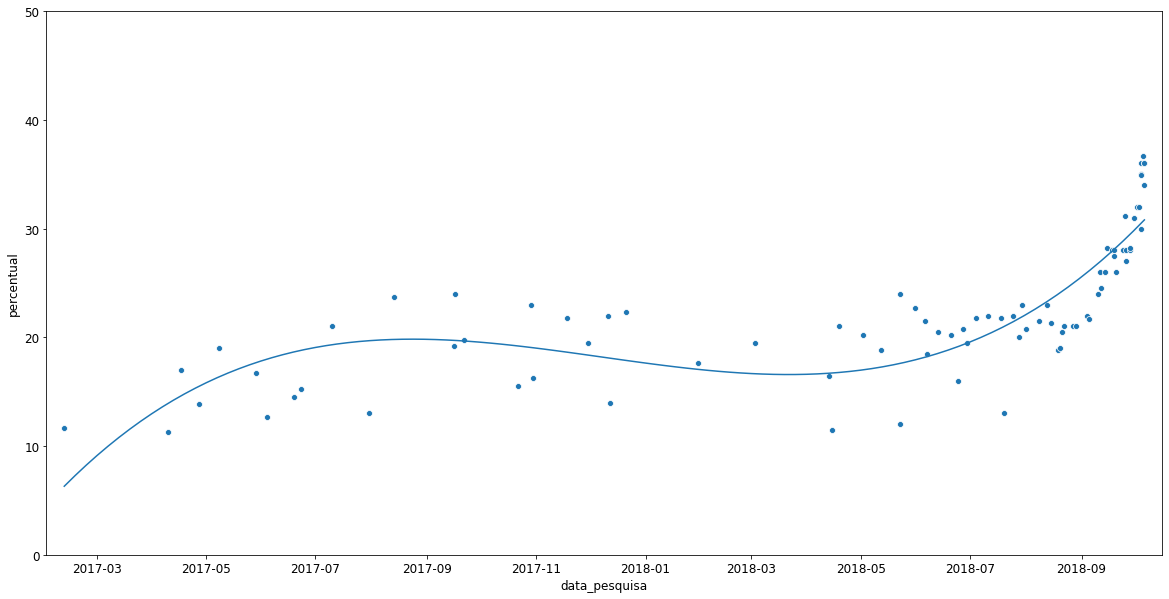

In [10]:
# turns dates into numbers
x = mdates.date2num(df_plot_redux.index)
y = df_plot_redux.percentual
# makes polinomial curve for our points, n-th degree
n = 3
z = np.polyfit(x, y, n)
# sets dimension
p = np.poly1d(z)

# create continuous datapoints
xp = np.linspace(min(x), max(x), 100)


# plot polynomial regression
plt.plot(xp, p(xp), '-')
# plot discrete poll data
ax = sns.scatterplot(x=df_plot_redux.index,
                     y=df_plot_redux.percentual,
                     data=df_plot_redux)

# set plot limits
lim = ax.set(xlim=(min(x)-10, max(x)+10),
             ylim=(0, 50))

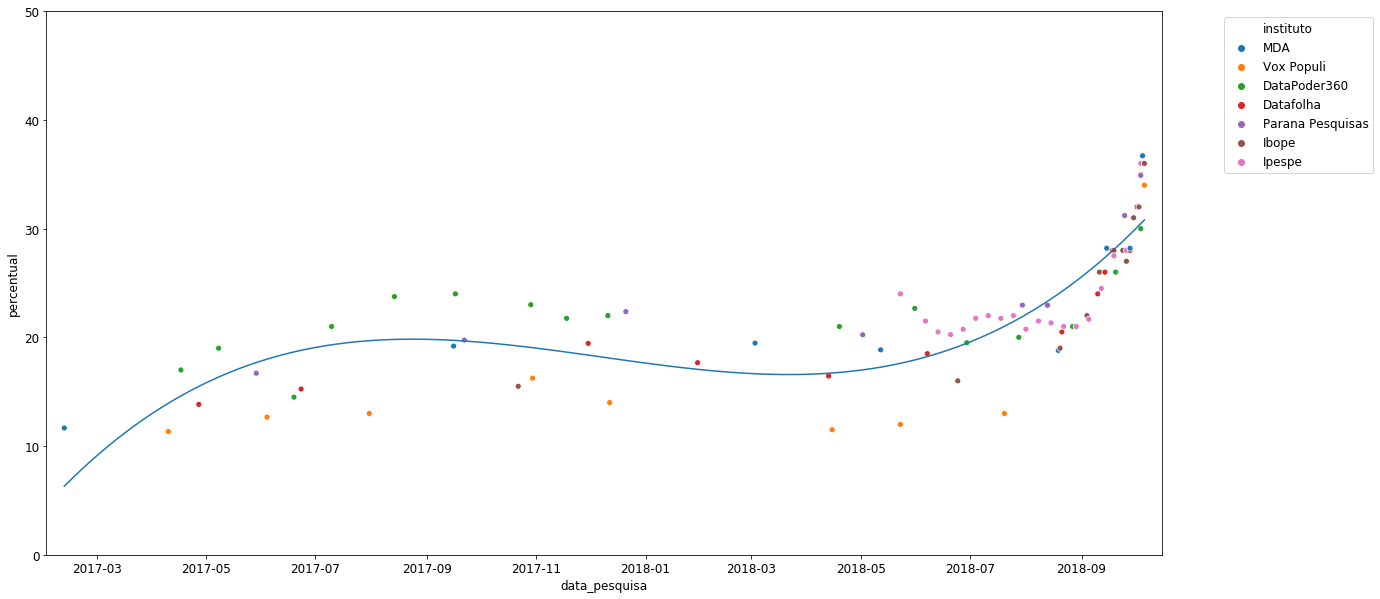

In [11]:
# now separated by polling institutes
plt.plot(xp, p(xp), '-')
ax = sns.scatterplot(x=df_plot_redux.index,
                     y=df_plot_redux.percentual,
                     hue=df_plot_redux.instituto,
                     data=df_plot_redux)

# set plot limits
ax.set(xlim=(min(x)-10, max(x)+10),
       ylim=(0, 50))
# move legend outside graph
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Acima vemos a regressão polinomial que gerou a extrapolação dos dados das pesquisas eleitorais.  
Usamos estes dados como classe alvo no nosso modelo!

In [12]:
d = mdates.date2num(df_tweets["created_at"])
popularidade = p(d).clip(min=0)

df_tweets['popularidade'] = popularidade
df_tweets.drop(columns=['created_at'])
#df_tweets.to_csv("pocketDF.csv", index=False)

## <span style="color:blueviolet">Criando e otimizando o modelo</span>

In [13]:
df_tweets.drop(columns=['text'], inplace=True)

In [14]:
df_tweets_train = df_tweets.sample(frac=0.8, random_state=42)
df_tweets_test = df_tweets.drop(df_tweets_train.index)

train_col_
df_train_x = df_tweets_train.drop(columns=['popularidade', 'created_at'])
df_train_y = df_tweets_train['popularidade']

df_test_x = df_tweets_test.drop(columns=['popularidade', 'created_at'])
df_test_y = df_tweets_test['popularidade']

In [15]:
regr = RandomForestRegressor(n_estimators=500, random_state=42)
regr.fit(df_train_x, df_train_y)
regr.score(df_test_x, df_test_y)

0.6609779469852993

Características mais importantes para previsão:

In [16]:
list(zip(regr.feature_importances_, df_tweets.drop(columns=['popularidade', 'created_at']).columns))

[(0.6120340410124172, 'retweet_count'),
 (0.13649522866562644, 'favorite_count'),
 (0.034498529859310796, 'sentimento'),
 (0.027467543688477057, 'subjetividade'),
 (0.012929213279987242, 'ADJ'),
 (0.018127610662588757, 'ADP'),
 (0.013562330480059765, 'ADV'),
 (0.008508808546537702, 'CONJ'),
 (0.016337816168419807, 'DET'),
 (0.04653135407766435, 'NOUN'),
 (0.012018632074552317, 'NUM'),
 (0.007919783329587359, 'PRT'),
 (0.012820536270932194, 'PRON'),
 (0.040006199828156126, 'VERB'),
 (0.0, '.'),
 (0.0007423720556830101, 'X')]

### <span style="color:blueviolet">GRIDSEARCH</span>

In [ ]:
n_estimators = [10, 50, 100, 200, 400, 800]
max_depth = [None, 5, 15, 25, 50]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5, 10, 15]

hyperF = dict(n_estimators = n_estimators,
              max_depth = max_depth,
              min_samples_split = min_samples_split,
              min_samples_leaf = min_samples_leaf)

forest = RandomForestRegressor(n_jobs=-1, random_state=42)

gridF = GridSearchCV(forest,
                     hyperF,
                     cv=5,
                     verbose=1,
                     n_jobs=-1)

bestF = gridF.fit(df_train_x, df_train_y)

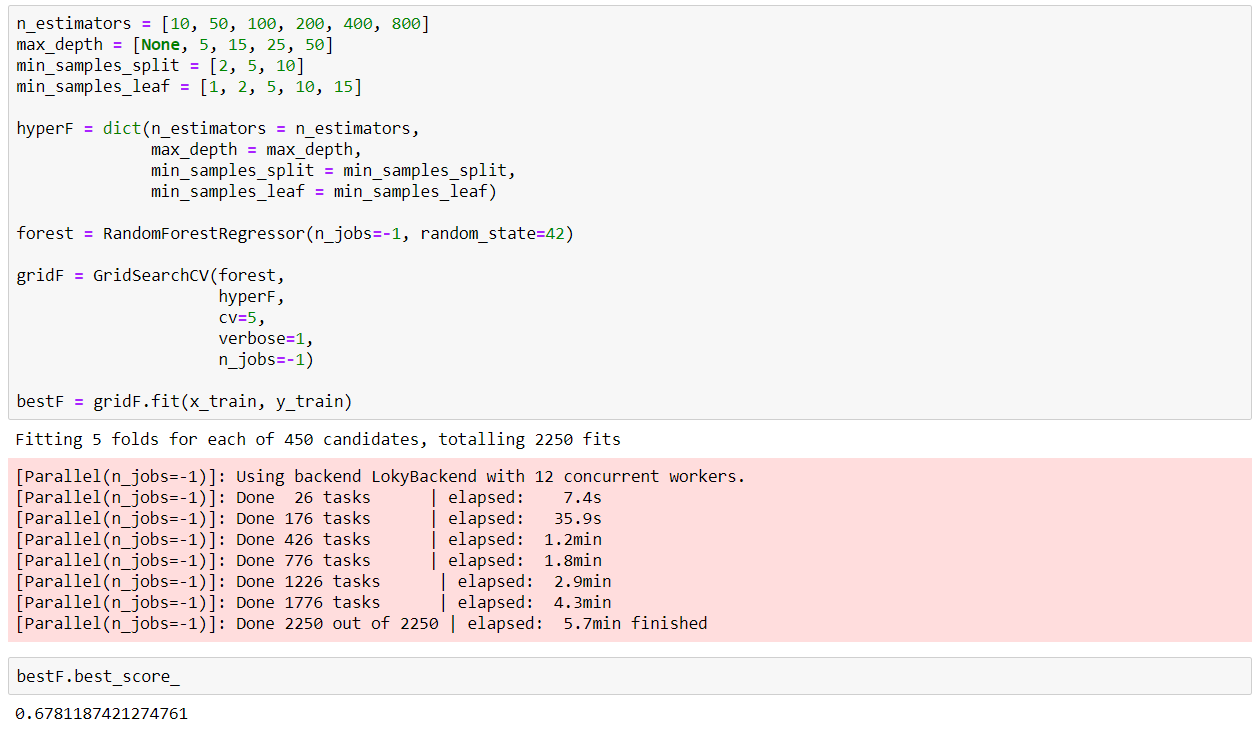

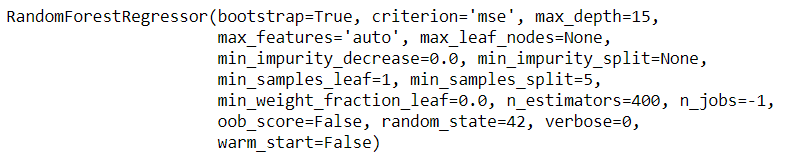

## <span style="color:blueviolet">""MATRIZ DE CONFUSÃO""</span>

In [19]:
regr = RandomForestRegressor(n_estimators=500, min_samples_split=4, min_samples_leaf=4, random_state=42)
regr.fit(df_train_x, df_train_y)
predict = regr.predict(df_test_x)

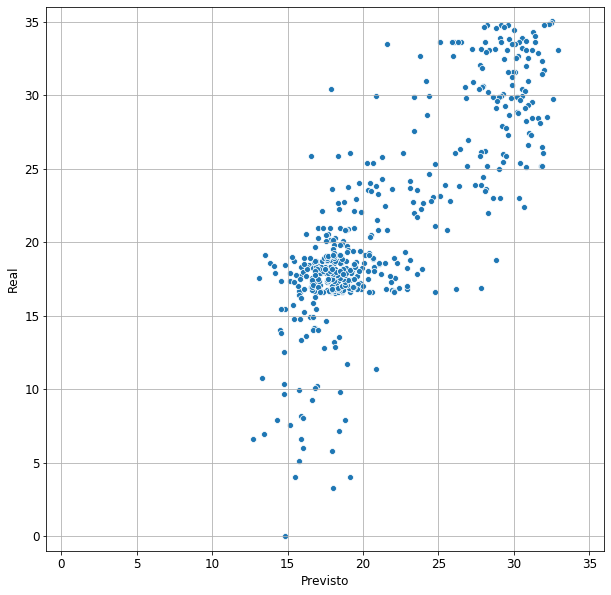

In [31]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 12})

ax = sns.scatterplot(x=predict,
                     y=df_test_y)
plt.xlabel("Previsto")
plt.ylabel("Real")
ax.set(xlim=(-1, 36),
       ylim=(-1, 36))
plt.grid()

## <span style="color:blueviolet">Parte II</span>
- <span style="color:coral">(a) utilizando redes neurais</span>

In [3]:
from funcoesTp2 import *
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
'''
params:
    X, y = dataset initialized in funcoesTp2.py and converted to numpy matrices
    dnn_model = neural network modeled in funcoesTp2.py
'''
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=dnn_model, epochs=100, batch_size=100, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(pipeline, X, y, cv=kfold)







Epoch 1/100
1856/1856 [==============================] - 4s 2ms/step - loss: 396.8753
Epoch 2/100
1856/1856 [==============================] - 0s 21us/step - loss: 395.2629
Epoch 3/100
1856/1856 [==============================] - 0s 21us/step - loss: 392.9327
Epoch 4/100
1856/1856 [==============================] - 0s 22us/step - loss: 389.4423
Epoch 5/100
1856/1856 [==============================] - 0s 21us/step - loss: 384.6476
Epoch 6/100
1856/1856 [==============================] - 0s 20us/step - loss: 378.3555
Epoch 7/100
1856/1856 [==============================] - 0s 21us/step - loss: 370.7634
Epoch 8/100
1856/1856 [==============================] - 0s 21us/step - loss: 361.9003
Epoch 9/100
1856/1856 [==============================] - 0s 20us/step - loss: 351.7879
Epoch 10/100
1856/1856 [==============================] - 0s 21us/step - loss: 340.7091
Epoch 11/100
1856/1856 [==============================] - 0s 20us/step - loss: 328.6545
Epoch 12/100
1856/1856 [============

1856/1856 [==============================] - 0s 22us/step - loss: 11.1505
Epoch 81/100
1856/1856 [==============================] - 0s 20us/step - loss: 11.1050
Epoch 82/100
1856/1856 [==============================] - 0s 20us/step - loss: 11.0693
Epoch 83/100
1856/1856 [==============================] - 0s 21us/step - loss: 11.0372
Epoch 84/100
1856/1856 [==============================] - 0s 20us/step - loss: 11.0025
Epoch 85/100
1856/1856 [==============================] - 0s 20us/step - loss: 10.9824
Epoch 86/100
1856/1856 [==============================] - 0s 20us/step - loss: 10.9450
Epoch 87/100
1856/1856 [==============================] - 0s 20us/step - loss: 10.9290
Epoch 88/100
1856/1856 [==============================] - 0s 21us/step - loss: 10.9066
Epoch 89/100
1856/1856 [==============================] - 0s 20us/step - loss: 10.8816
Epoch 90/100
1856/1856 [==============================] - 0s 20us/step - loss: 10.8644
Epoch 91/100
1856/1856 [==============================] 

1857/1857 [==============================] - 0s 20us/step - loss: 31.6936
Epoch 74/100
1857/1857 [==============================] - 0s 21us/step - loss: 31.2775
Epoch 75/100
1857/1857 [==============================] - 0s 20us/step - loss: 30.8793
Epoch 76/100
1857/1857 [==============================] - 0s 20us/step - loss: 30.4955
Epoch 77/100
1857/1857 [==============================] - 0s 20us/step - loss: 30.1431
Epoch 78/100
1857/1857 [==============================] - 0s 20us/step - loss: 29.7991
Epoch 79/100
1857/1857 [==============================] - 0s 20us/step - loss: 29.4687
Epoch 80/100
1857/1857 [==============================] - 0s 20us/step - loss: 29.1632
Epoch 81/100
1857/1857 [==============================] - 0s 20us/step - loss: 28.8819
Epoch 82/100
1857/1857 [==============================] - 0s 19us/step - loss: 28.5856
Epoch 83/100
1857/1857 [==============================] - 0s 20us/step - loss: 28.3166
Epoch 84/100
1857/1857 [==============================] 

1857/1857 [==============================] - 0s 20us/step - loss: 33.3615
Epoch 67/100
1857/1857 [==============================] - 0s 20us/step - loss: 32.4651
Epoch 68/100
1857/1857 [==============================] - 0s 20us/step - loss: 31.6079
Epoch 69/100
1857/1857 [==============================] - 0s 21us/step - loss: 30.8141
Epoch 70/100
1857/1857 [==============================] - 0s 20us/step - loss: 30.0641
Epoch 71/100
1857/1857 [==============================] - 0s 20us/step - loss: 29.3745
Epoch 72/100
1857/1857 [==============================] - 0s 21us/step - loss: 28.7315
Epoch 73/100
1857/1857 [==============================] - 0s 20us/step - loss: 28.1029
Epoch 74/100
1857/1857 [==============================] - 0s 20us/step - loss: 27.5285
Epoch 75/100
1857/1857 [==============================] - 0s 20us/step - loss: 26.9852
Epoch 76/100
1857/1857 [==============================] - 0s 20us/step - loss: 26.4796
Epoch 77/100
1857/1857 [==============================] 

1857/1857 [==============================] - 0s 21us/step - loss: 41.2767
Epoch 60/100
1857/1857 [==============================] - 0s 20us/step - loss: 39.8143
Epoch 61/100
1857/1857 [==============================] - 0s 21us/step - loss: 38.4589
Epoch 62/100
1857/1857 [==============================] - 0s 21us/step - loss: 37.1953
Epoch 63/100
1857/1857 [==============================] - 0s 21us/step - loss: 36.0359
Epoch 64/100
1857/1857 [==============================] - 0s 20us/step - loss: 34.9804
Epoch 65/100
1857/1857 [==============================] - 0s 20us/step - loss: 33.9696
Epoch 66/100
1857/1857 [==============================] - 0s 20us/step - loss: 33.0399
Epoch 67/100
1857/1857 [==============================] - 0s 20us/step - loss: 32.1816
Epoch 68/100
1857/1857 [==============================] - 0s 20us/step - loss: 31.3769
Epoch 69/100
1857/1857 [==============================] - 0s 20us/step - loss: 30.6253
Epoch 70/100
1857/1857 [==============================] 

1857/1857 [==============================] - 0s 22us/step - loss: 53.4399
Epoch 53/100
1857/1857 [==============================] - 0s 20us/step - loss: 50.8850
Epoch 54/100
1857/1857 [==============================] - 0s 20us/step - loss: 48.5392
Epoch 55/100
1857/1857 [==============================] - 0s 21us/step - loss: 46.3859
Epoch 56/100
1857/1857 [==============================] - 0s 22us/step - loss: 44.3833
Epoch 57/100
1857/1857 [==============================] - 0s 21us/step - loss: 42.5451
Epoch 58/100
1857/1857 [==============================] - 0s 22us/step - loss: 40.8462
Epoch 59/100
1857/1857 [==============================] - 0s 20us/step - loss: 39.2794
Epoch 60/100
1857/1857 [==============================] - 0s 20us/step - loss: 37.8644
Epoch 61/100
1857/1857 [==============================] - 0s 20us/step - loss: 36.5270
Epoch 62/100
1857/1857 [==============================] - 0s 20us/step - loss: 35.3002
Epoch 63/100
1857/1857 [==============================] 

In [6]:
# MSE
mean_squared_error = -results.mean()
mean_squared_error

30.678372052995904

In [7]:
# r2 score
r2 = 1 + results.mean()/((y - y.mean())**2).mean()
r2

0.2599456994319982

<p align="justify">Vemos que após uma modelagem curta de uma rede neural profunda, o modelo não foi capaz de atingir uma métrica comparável de raiz do erro nem de r2.  
Para termos de interpretação, o erro de 30.67 significa que cada previsão de popularidade do candidato tem uma média de 5.53 pontos percentuais de erro, que é bem pior do que o resultado alcançado pelo modelo RandomForest e também pior do que as pesquisas eleitorais.</p>

<p align="justify">Aprendemos com esse item que redes neurais são poderosas, mas demandam um ajuste minuto para obter suas vantagens, variações no número de camadas, nodos por camadas, função de ativação e número de épocas podem influenciar em muito os resultados obtidos.  
Uma última nota é que talvez seja vantajoso modelar o problema com tipos mais complexos de redes neurais, como as recorrentes, vista a natureza temporal do problema onde as métricas de um post em rede social podem carregar atributos que influenciam o próximo post (um post bem sucedido pode carregar parte da sua popularidade pro próximo post ou um post parecido).</p>